## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3007336/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3007336/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3007336/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3007336/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3007336/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3007336/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3007336/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
# Import necessary libraries
from delta.tables import *
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from pyspark.sql.types import *
from pyspark.sql import functions as psf
import json
from pyspark.sql.streaming import *
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr, regexp_extract, regexp_replace, to_timestamp, input_file_name, current_timestamp, udf, desc, sum as sql_sum, when
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType, IntegerType
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import boto3, botocore
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString
from sklearn.metrics import confusion_matrix, classification_report

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Using the utility functions
TWEET_BUCKET_NAME = 'voc-75-databricks-data'
df_source_listing = get_source_listing_df()  

# Count the number of source files
num_files = len(df_source_listing)
print(f"Number of source files: {num_files}")

Number of source files: 200001


In [0]:
# print the contents of one of the files
if num_files > 0:
    first_file_contents = show_s3_file_contents(df_source_listing.iloc[0]['File Name'])  # Pass only one argument
    print("Contents of the first file:")
    print(first_file_contents)

Contents of the first file:
b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
# Define the schema for the JSON data
raw_data_schema = StructType([
    StructField("date", StringType(), True), 
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("source_file", StringType(), True),
    StructField("processing_time", TimestampType(), True)
])


In [0]:
# Setup read stream
streaming_df = (
    spark.readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")
    .schema(raw_data_schema)
    .load(TWEET_SOURCE_PATH)
    .withColumn("source_file", input_file_name())
    .withColumn("processing_time", current_timestamp())
)


In [0]:
# Write the transformed data to the Bronze Delta table
bronze_stream = (
    streaming_df.writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", BRONZE_CHECKPOINT)
    .trigger(once=True)
    .option("mergeSchema", "true")
    .start(BRONZE_DELTA)
)

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

In [0]:
# Count the Total Number of Tweets
total_tweets = bronze_df.count()
print(f"Total number of tweets captured in Bronze Table: {total_tweets}")

Total number of tweets captured in Bronze Table: 200000


In [0]:
# Calculate null values in each column
null_counts = bronze_df.select([sql_sum(col(c).isNull().cast("int")).alias(c) for c in bronze_df.columns])
null_counts.show()

+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [0]:
# count Tweets by Each Unique User
user_tweet_counts = bronze_df.groupBy("user").count().orderBy(desc("count"))
print("Top 20 users by tweet count:")
user_tweet_counts.show(20)


Top 20 users by tweet count:
+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  310|
|     nuttychris|  129|
|      iHomeTech|   81|
|       tsarnick|   77|
| Hollywood_Trey|   71|
|  divxdownloads|   68|
|      lesley007|   65|
|  redrobinrockn|   58|
|    MissxMarisa|   57|
|     SarahSaner|   56|
|     sebby_peek|   55|
|        kasey79|   54|
|torilovesbradie|   51|
|    whitsundays|   51|
|         keza34|   49|
| MiDesfileNegro|   48|
|        Dogbook|   47|
|   TraceyHewins|   46|
|    effingcards|   43|
|         Djalfy|   43|
+---------------+-----+
only showing top 20 rows



In [0]:
# Count Tweets with and Without Mentions
tweets_with_mentions = bronze_df.filter(col("text").contains("@")).count()
tweets_without_mentions = total_tweets - tweets_with_mentions

print(f"Tweets with at least one mention: {tweets_with_mentions}")
print(f"Tweets with no mentions: {tweets_without_mentions}")


Tweets with at least one mention: 93817
Tweets with no mentions: 106183


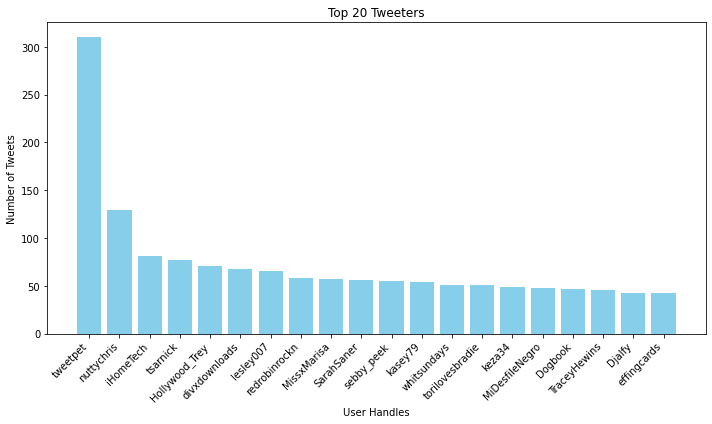

In [0]:
# Convert to pandas DataFrame
pd_tweets_by_user = user_tweet_counts.limit(20).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pd_tweets_by_user['user'], pd_tweets_by_user['count'], color='skyblue')
plt.xlabel('User Handles')
plt.ylabel('Number of Tweets')
plt.title('Top 20 Tweeters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
# Read from Bronze Delta Table
bronze_df = spark.readStream \
    .format("delta") \
    .load(BRONZE_DELTA)


In [0]:
silver_df = bronze_df \
    .withColumn("timestamp", to_timestamp("date", "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("mention", expr("regexp_extract(text, '(@\\w+)', 0)")) \
    .withColumn("cleaned_text", regexp_replace("text", "@\\w+", "")) \
    .select(
        col("timestamp"),
        col("mention"),
        col("cleaned_text"),
        col("sentiment")
    )

In [0]:
# Set up a write stream to append to the Silver Delta table
silver_stream = (
    silver_df.writeStream
    .format("delta")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .outputMode("append")
    .trigger(once=True)
    .queryName("silver_stream")  # Naming the stream for easier monitoring
    .start(SILVER_DELTA)
)

In [0]:
# Await termination or programmatically stop the stream
silver_stream.awaitTermination()

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# Load the pretrained model as a Spark UDF
model_uri = "models:/HF_TWEET_SENTIMENT/Production"
predict_udf = mlflow.pyfunc.spark_udf(spark, model_uri, result_type=FloatType())

/local_disk0/.ephemeral_nfs/envs/pythonEnv-742948a6-3d2c-40f3-8c23-4de35384dd11/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/12 03:11:36 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 03:11:41 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/12 03:11:41 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 03:11:42 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
# Read from Silver Delta Table
silver_df = spark.readStream.format("delta").load(SILVER_DELTA)

In [0]:
# Define transformation logic to derive additional fields
gold_df = silver_df.select(
    col("timestamp"),
    col("mention"),
    col("cleaned_text"),
    col("sentiment"),
    predict_udf(col("cleaned_text")).alias("predicted_score"),
    when(predict_udf(col("cleaned_text")) > 0.5, "positive").otherwise("negative").alias("predicted_sentiment"),
    when(col("sentiment") == "positive", 1).otherwise(0).alias("sentiment_id"),
    when(predict_udf(col("cleaned_text")) > 0.5, 1).otherwise(0).alias("predicted_sentiment_id")
)

In [0]:
# Cast predicted_score to double to match the schema
gold_df = gold_df.withColumn("predicted_score", col("predicted_score").cast("double"))

# Write the transformed Gold Data to the Gold Delta table
gold_stream = gold_df.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", GOLD_CHECKPOINT) \
    .trigger(once=True) \
    .start(GOLD_DELTA)

In [0]:
gold_df

Out[40]: DataFrame[timestamp: timestamp, mention: string, cleaned_text: string, sentiment: string, predicted_score: double, predicted_sentiment: string, sentiment_id: int, predicted_sentiment_id: int]

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


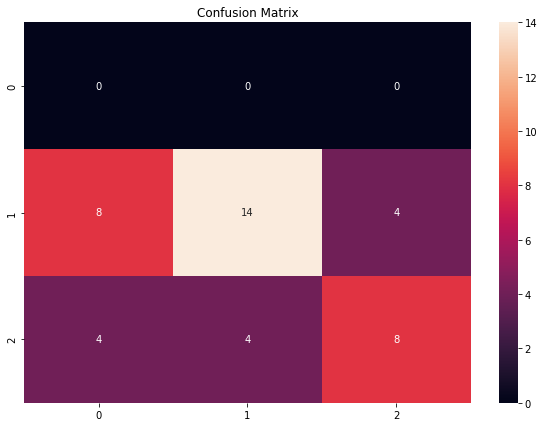

In [0]:
import mlflow
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure you set the tracking URI and start a run
mlflow.set_tracking_uri("databricks")
with mlflow.start_run():
    # Read data from the Gold Delta Table
    gold_df = spark.read.format("delta").load("/tmp/labuser104917-2387441/gold.delta")
    pandas_df = gold_df.select("sentiment_id", "predicted_sentiment_id").toPandas()
    
    # Calculate metrics
    report = classification_report(pandas_df['sentiment_id'], pandas_df['predicted_sentiment_id'], output_dict=True)
    conf_matrix = confusion_matrix(pandas_df['sentiment_id'], pandas_df['predicted_sentiment_id'])
    
    # Log metrics
    mlflow.log_metric("precision", report['weighted avg']['precision'])
    mlflow.log_metric("recall", report['weighted avg']['recall'])
    mlflow.log_metric("f1-score", report['weighted avg']['f1-score'])
    
    # Log confusion matrix as an image
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.savefig("/tmp/confusion_matrix.png")
    mlflow.log_artifact("/tmp/confusion_matrix.png")
    
    # Log model details
    mlflow.log_param("model_name", "HF_TWEET_SENTIMENT")
    mlflow.log_param("model_version", "1.0")
    mlflow.log_param("delta_table_version", "silver_table_version_here")  


## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
from pyspark.sql.functions import col, count, sum, when

# Read data from the Gold Delta Table
gold_df = spark.read.format("delta").load("/tmp/labuser104917-2387441/gold.delta")

# Ensure the 'sentiment' column exists and categorize sentiments
gold_df = gold_df.withColumn("positive", when(col("sentiment") == "positive", 1).otherwise(0))
gold_df = gold_df.withColumn("negative", when(col("sentiment") == "negative", 1).otherwise(0))
gold_df = gold_df.withColumn("neutral", when(col("sentiment") == "neutral", 1).otherwise(0))

# Aggregate counts by mention
sentiment_counts = gold_df.groupBy("mention").agg(
    count("mention").alias("total_mentions"),
    sum(col("positive").cast("integer")).alias("positive_count"),
    sum(col("negative").cast("integer")).alias("negative_count"),
    sum(col("neutral").cast("integer")).alias("neutral_count")
).cache()  # Use cache if you're going to use this DataFrame multiple times

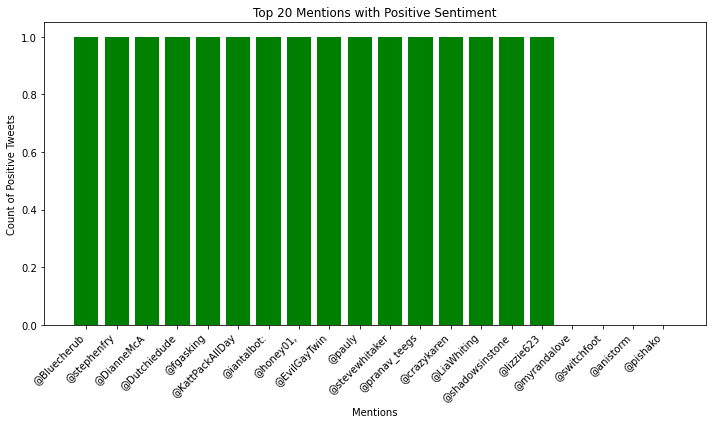

In [0]:
# Find the top 20 mentions with positive sentiment
top_positive = sentiment_counts.orderBy(col("positive_count").desc()).limit(20).toPandas()

# Plot top 20 mentions with positive sentiment
plt.figure(figsize=(10, 6))
plt.bar(top_positive['mention'], top_positive['positive_count'], color='green')
plt.xlabel('Mentions')
plt.ylabel('Count of Positive Tweets')
plt.title('Top 20 Mentions with Positive Sentiment')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

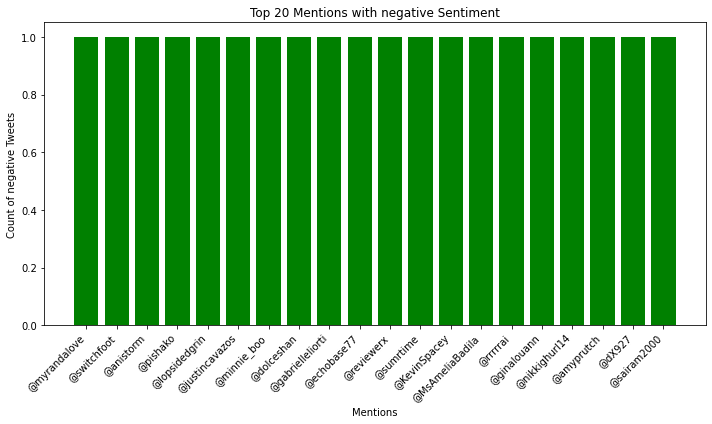

In [0]:
# Find the top 20 mentions with negative sentiment
top_negative = sentiment_counts.orderBy(col("negative_count").desc()).limit(20).toPandas()

# Plot top 20 mentions with negative sentiment
plt.figure(figsize=(10, 6))
plt.bar(top_negative['mention'], top_negative['negative_count'], color='green')
plt.xlabel('Mentions')
plt.ylabel('Count of negative Tweets')
plt.title('Top 20 Mentions with negative Sentiment')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
from pyspark.sql import SparkSession
import time

# Assuming the start time was captured at the beginning of the notebook
start_time = time.time()

# Get the Spark session
spark = SparkSession.builder.getOrCreate()

# List all active streams
print("Listing all active streams:")
for stream in spark.streams.active:
    print(f"Stream Name: {stream.name}, Stream ID: {stream.id}")

# Stop all active streams
for stream in spark.streams.active:
    print(f"Stopping stream: {stream.name}")
    stream.stop()

# Calculate and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time of the notebook: {elapsed_time} seconds")


Listing all active streams:
Elapsed time of the notebook: 0.010938167572021484 seconds


In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()

## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

Spill: Spilling occurs when the data being processed does not fit into memory, causing Spark to write data to disk. This can degrade performance because disk operations are significantly slower than in-memory operations. This is not too obvious for my project.Increasing the memory allocation for your Spark executors can help reduce spill but this is not the case for me. One example for improvement is to consider filtering data earlier in my pipelines or adjusting the spark.memory.fraction to allocate more memory for execution instead of storage.

Skew: Data skew occurs when the data is unevenly distributed across partitions, resulting in certain tasks taking much longer to complete than others. This is the biggest problem in all three of my tables (bronze, silver and gold). This significantly reduced my streaming speed so that I had to rely on using "trigger". Addressing skew might involve repartitioning the data based on a more evenly distributed key or increasing the number of partitions. Techniques like salting can also be used during joins to distribute the load more evenly.

Shuffle: Shuffle occurs when data needs to be redistributed across partitions to perform certain operations like sorting or aggregation. It is often the most expensive operation in terms of network and disk I/O. I  However, I did not use my strategies to reduce shuffle such as minimizing the operations that require shuffling. 

Storage: Inefficient storage involves the persistence and retrieval of data, affected by the choice of data format and serialization. Small files is another big problem I encourtered during the project. It further led to spills and skews. I used cache but it did not help improve my situation.

Serialization: Serialization is the process of converting data structures or object states into a format that can be stored and reconstructed later. Inefficient serialization can increase the data size and the overhead of network transmission. I did not use any improvement strategy with serialization. 